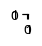

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, PairedVAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180

In [4]:
pos_df = pd.read_csv('../data/filtered/230927_nettcr_positives_only.csv')

In [14]:
# This is the swapped dataset
b = pd.read_csv('../data/NetTCR/nettcr_train_mathias_with_swaps.csv')
b.to_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv', index=False)

In [223]:
c = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
c.query('input_type=="paired"').to_csv('../data/filtered/231212_nettcr_expanded_pairedAB_412peps_with_swaps.csv', index=False)

In [2]:
def encode_cat(sequence, max_len):
    return F.pad(torch.tensor([CHAR_TO_INT[x] for x in sequence]), (0, max_len-(len(sequence))), value=-1)

def batch_encode_cat(sequences, max_len):
    return torch.stack([encode_cat(x, max_len) for x in sequences])

In [4]:
from src.data_processing import encode_batch, CHAR_TO_INT
from src.models import FullTCRVAE
from src.datasets import TCRpMHCDataset, TCRSpecificDataset
df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
model = FullTCRVAE(0, 0, 22, 0, 0, 23, 'BL50LO', hidden_dim=128, latent_dim=64)
model = load_checkpoint(model, '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt')
model.eval()
df['set'] = df['partition'].apply(lambda x: 'valid' if x==0 else 'train')

dataset = TCRSpecificDataset(df, 0, 0, 22, 0, 0, 23, 'BL50LO', 
                              -20,'A1', 'A2', 'A3', 'B1', 'B2', 'B3')

with torch.no_grad():
    z_embed = model.embed(dataset.x)
encoded_peps = batch_encode_cat(df['peptide'], 12)

Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [5]:
z=torch.normal(torch.tensor([-0.05]*10), torch.tensor([2]*10))
F.sigmoid(z), z

(tensor([0.7376, 0.8379, 0.4941, 0.4256, 0.0361, 0.0307, 0.0446, 0.1592, 0.2854,
         0.4761]),
 tensor([ 1.0333,  1.6430, -0.0234, -0.2998, -3.2851, -3.4526, -3.0650, -1.6641,
         -0.9176, -0.0956]))

In [8]:
from src.torch_utils import load_model_full
ckpt = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt'
js = '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json'
model = load_model_full(ckpt, js)


Reloading best model:
Best epoch: 24959
total: 0.2867068297915406
reconstruction: 0.2530093719624275
kld: 0.006973478481103337
triplet: 0.02672399799200579
seq_accuracy: 0.9099540710449219
v_accuracy: 0
j_accuracy: 0


In [13]:
args = {'folder': '../output/TripletTest/231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_7VzZ5/231108_TripletCosine_A3B3_margin01_25k_epochs_larger_model_KFold_0_231130_2321_5PXfp/'}
checkpoint_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.pt'), os.listdir(args['folder'])))
json_file = next(filter(lambda x: x.startswith('checkpoint') and x.endswith('.json'), os.listdir(args['folder'])))

In [15]:
checkpoint_file,  json_file

('checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs.pt',
 'checkpoint_best_fold00_kcv_230927_nettcr_positives_only_f00_231108_TripletCosine_A3B3_margin_Auto_25k_epochs_larger_model_KFold_0_231130_2321_eLRQs_JSON_kwargs.json')

In [11]:
n_layers=1
for _ in range(n_layers-1):
    print('xd')

In [9]:
model

FullTCRVAE(
  (encoder): Sequential(
    (0): Linear(in_features=900, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=128, bias=True)
    (3): SELU()
  )
  (encoder_mu): Linear(in_features=128, out_features=64, bias=True)
  (encoder_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): SELU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): SELU()
  )
  (decoder_sequence): Sequential(
    (0): Linear(in_features=128, out_features=450, bias=True)
    (1): SELU()
    (2): Linear(in_features=450, out_features=900, bias=True)
  )
)

# results comparison 

Using various FROZEN VAEs with A3-B3, with or without triplet loss
- NH 50
- dropout 0.25
- BatchNorm
- 1 in_layer, 1 hidden layer, 1 out_layer (n_latent+pep_dim -> n_hidden -> n_hidden -> n_out (1))
- 1000 epochs

In [51]:
import glob

['../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_4_231206_1319_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_1_231206_1302_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_3_231206_1313_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_0_231206_1257_Ds1PC',
 '../output/Ds1PC/CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_25k_AutoSmall_KFold_2_231206_1308_Ds1PC']

In [71]:
peporder = df.query('binder==1').groupby('peptide').agg(count=('B3', 'count')).sort_values('count', ascending=False)
peporder, count = peporder.index, peporder.values

In [79]:
name = f.split('Swaps_')[1].split('_KFold')[0]
name

'Cos_25k_AutoSmall'

In [101]:
from src.metrics import get_metrics
# Get predictions per peptide, hue by model -> do a scatter plot of 5 folds?

def get_per_pep_fold_metrics(d):
    results = []
    for i, f in enumerate(sorted(glob.glob(d+'/*'))):
        name = f.split('Swaps_')[1].split('_KFold')[0]
        run_id = f.split('_')[-1]
        pf = next(filter(lambda x:'pred' in x and x.endswith('.csv'), os.listdir(f)))
        
        preds = pd.read_csv(f+'/'+pf)
        for pep in peporder:
            tmp = preds.query('peptide==@pep')
            res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
            metrics = get_metrics(tmp['binder'], tmp['pred_prob'])
            res.update(metrics)
            results.append(res)
    return pd.DataFrame(results)

In [ ]:
CLF_Nh50_Do025_True_nl1_ne1000_withSwaps_Cos_10k_Auto_KFold_1_231206_1137_5U0XJ

In [243]:
dirs = glob.glob('../output/classifier_results/*')
dirs

['../output/classifier_results/NoTrp_10k_Small_BeIgZ',
 '../output/classifier_results/Cos_25k_01_Large_7VzZ5',
 '../output/classifier_results/Cos_10k_Auto_5U0XJ',
 '../output/classifier_results/Cos_Large_BNDO_m2CkN',
 '../output/classifier_results/Cos25k_MoreData_COSA3B3',
 '../output/classifier_results/CLF_FlippedBNDO_Cos25k_Large_7VzZ5',
 '../output/classifier_results/Old_LowKLD_Large_p6da2',
 '../output/classifier_results/L2_10k_Auto_Qg0vv',
 '../output/classifier_results/Old_HighKLD_Large_LIWGn',
 '../output/classifier_results/Cos_25k_Auto_Small_Ds1PC',
 '../output/classifier_results/L2_25k_15_Large_rwUIQ',
 '../output/classifier_results/L2_25k_Auto_Small_V0dKW']

In [313]:
%ls ../output/ | grep classifier


classifier_flipped/
classifier_flipped_blosum/
classifier_flipped_decrease/
classifier_results/
classifier_results_BN_first/


[autoreload of src.models failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


In [316]:
noflip_res = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]).assign(type='noflip_res')
flipped_res = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped/*')]).assign(type='flipped_res')
flipped_blosum = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped_blosum/*')]).assign(type='flipped_blosum')
flipped_decre = pd.concat([get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_flipped_decrease/*')]).assign(type='flipped_decre')


In [320]:
print('noflip_res')
display(noflip_res.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_res')
display(flipped_res.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_blosum')
display(flipped_blosum.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))
print('flipped_decre')
display(flipped_decre.groupby(['name']).agg(mean_auc=('auc','mean'), max_auc=('auc','max'), mean_auc01=('auc_01', 'mean'),max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False).head(3))

noflip_res


,mean_auc,max_auc,mean_auc01,max_auc01
name,,,,
Old_25k_LowKLD_Large,0.679568,0.8925,0.578686,0.8026
CosLargeFlippedBNDO,0.679468,0.8858,0.580928,0.8009
Cos_25k_Larger_BNDO,0.677718,0.9094,0.588344,0.8246


flipped_res


,mean_auc,max_auc,mean_auc01,max_auc01
name,,,,
Old_25k_LowKLD_Large,0.687144,0.9449,0.585904,0.8613
L2_25k_15Large,0.681678,0.9309,0.590768,0.8947
Cos_25k_AutoSmall,0.681252,0.8706,0.580022,0.7895


flipped_blosum


,mean_auc,max_auc,mean_auc01,max_auc01
name,,,,
FLIPPED_BLOSUM_Cos_25k_01Large,0.731472,0.9355,0.617003,0.8557
FLIPPED_BLOSUM_Old_25k_LowKLD_Large,0.726170,0.9462,0.601805,0.8215
FLIPPED_BLOSUM_Cos_25k_AutoSmall,0.703865,1.0000,0.608531,1.0000


flipped_decre


,mean_auc,max_auc,mean_auc01,max_auc01
name,,,,
FLIPPED_Decrease_Old_25k_LowKLD_Large,0.686383,0.9099,0.586258,0.7957
FLIPPED_Decrease_Cos_25k_01Large,0.679834,0.9355,0.579960,0.8520
FLIPPED_Decrease_Old_25k_HiKLD_Large,0.671892,0.9677,0.579960,0.8302


In [ ]:
noflip_res = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]
flipped_res = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results_BN_first/*')]

In [291]:
myres = [get_per_pep_fold_metrics(d) for d in glob.glob('../output/classifier_results/*')]

In [292]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pep_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PepNoSim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [293]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pan_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanNoSim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [294]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_valid_pan_SimRescale_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanW/Sim-Valid'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [295]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_test_pan_no_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanNoSim-Test'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [296]:
nettcr = pd.read_csv('../data/NetTCR/nettcr22_test_pan_rescaled_w_sim_preds.csv')
results = []
for i, f in enumerate(sorted(nettcr.partition.unique())):
    name = 'NetTCR-2.2-PanWithSim-Test'
    run_id = 'N/A'
    nettcr_fold = nettcr.query('partition==@f')
    for pep in peporder:
        tmp = nettcr_fold.query('peptide==@pep')
        res = {'name':name, 'run_id':run_id, 'fold':i, 'peptide':pep}
        metrics = get_metrics(tmp['binder'], tmp['prediction'])
        res.update(metrics)
        results.append(res)
ntres = pd.DataFrame(results)
myres.append(ntres)

In [297]:
clfs = pd.concat(myres).query('name!="NetTCR-2.2"')
top10pep = peporder[:10]
clfs.name.unique()

array(['NoTrp_10k_Small', 'Cos_25k_01Large', 'Cos_10k_Auto',
       'Cos_25k_Larger_BNDO', 'Cos_25k_more_data', 'CosLargeFlippedBNDO',
       'Old_25k_LowKLD_Large', 'L2_10k_Auto', 'Old_25k_HiKLD_Large',
       'Cos_25k_AutoSmall', 'L2_25k_15Large', 'L2_25k_AutoSmall',
       'NetTCR-2.2-PepNoSim-Valid', 'NetTCR-2.2-PanNoSim-Valid',
       'NetTCR-2.2-PanW/Sim-Valid', 'NetTCR-2.2-PanNoSim-Test',
       'NetTCR-2.2-PanWithSim-Test'], dtype=object)

In [324]:
merged = pd.concat([flipped_blosum, pd.concat(myres)])

In [325]:
merged.groupby(['name']).agg(mean_auc=('auc','mean')).sort_values('mean_auc',ascending=False)

,mean_auc
name,
NetTCR-2.2-PepNoSim-Valid,0.854541
NetTCR-2.2-PanW/Sim-Valid,0.841110
NetTCR-2.2-PanWithSim-Test,0.839088
NetTCR-2.2-PanNoSim-Valid,0.830489
NetTCR-2.2-PanNoSim-Test,0.827348
FLIPPED_BLOSUM_Cos_25k_01Large,0.731472
FLIPPED_BLOSUM_Old_25k_LowKLD_Large,0.726170
FLIPPED_BLOSUM_Cos_25k_AutoSmall,0.703865
FLIPPED_BLOSUM_Old_25k_HiKLD_Large,0.701032


In [300]:
xx = sorted([x for x in clfs.name.unique() if 'nettcr' not in x.lower()])
xx

['CosLargeFlippedBNDO',
 'Cos_10k_Auto',
 'Cos_25k_01Large',
 'Cos_25k_AutoSmall',
 'Cos_25k_Larger_BNDO',
 'Cos_25k_more_data',
 'L2_10k_Auto',
 'L2_25k_15Large',
 'L2_25k_AutoSmall',
 'NoTrp_10k_Small',
 'Old_25k_HiKLD_Large',
 'Old_25k_LowKLD_Large']

In [302]:
yy = [x for x in clfs.name.unique() if 'nettcr' in x.lower()]
yy

['NetTCR-2.2-PepNoSim-Valid',
 'NetTCR-2.2-PanNoSim-Valid',
 'NetTCR-2.2-PanW/Sim-Valid',
 'NetTCR-2.2-PanNoSim-Test',
 'NetTCR-2.2-PanWithSim-Test']

## Messy plots with all models

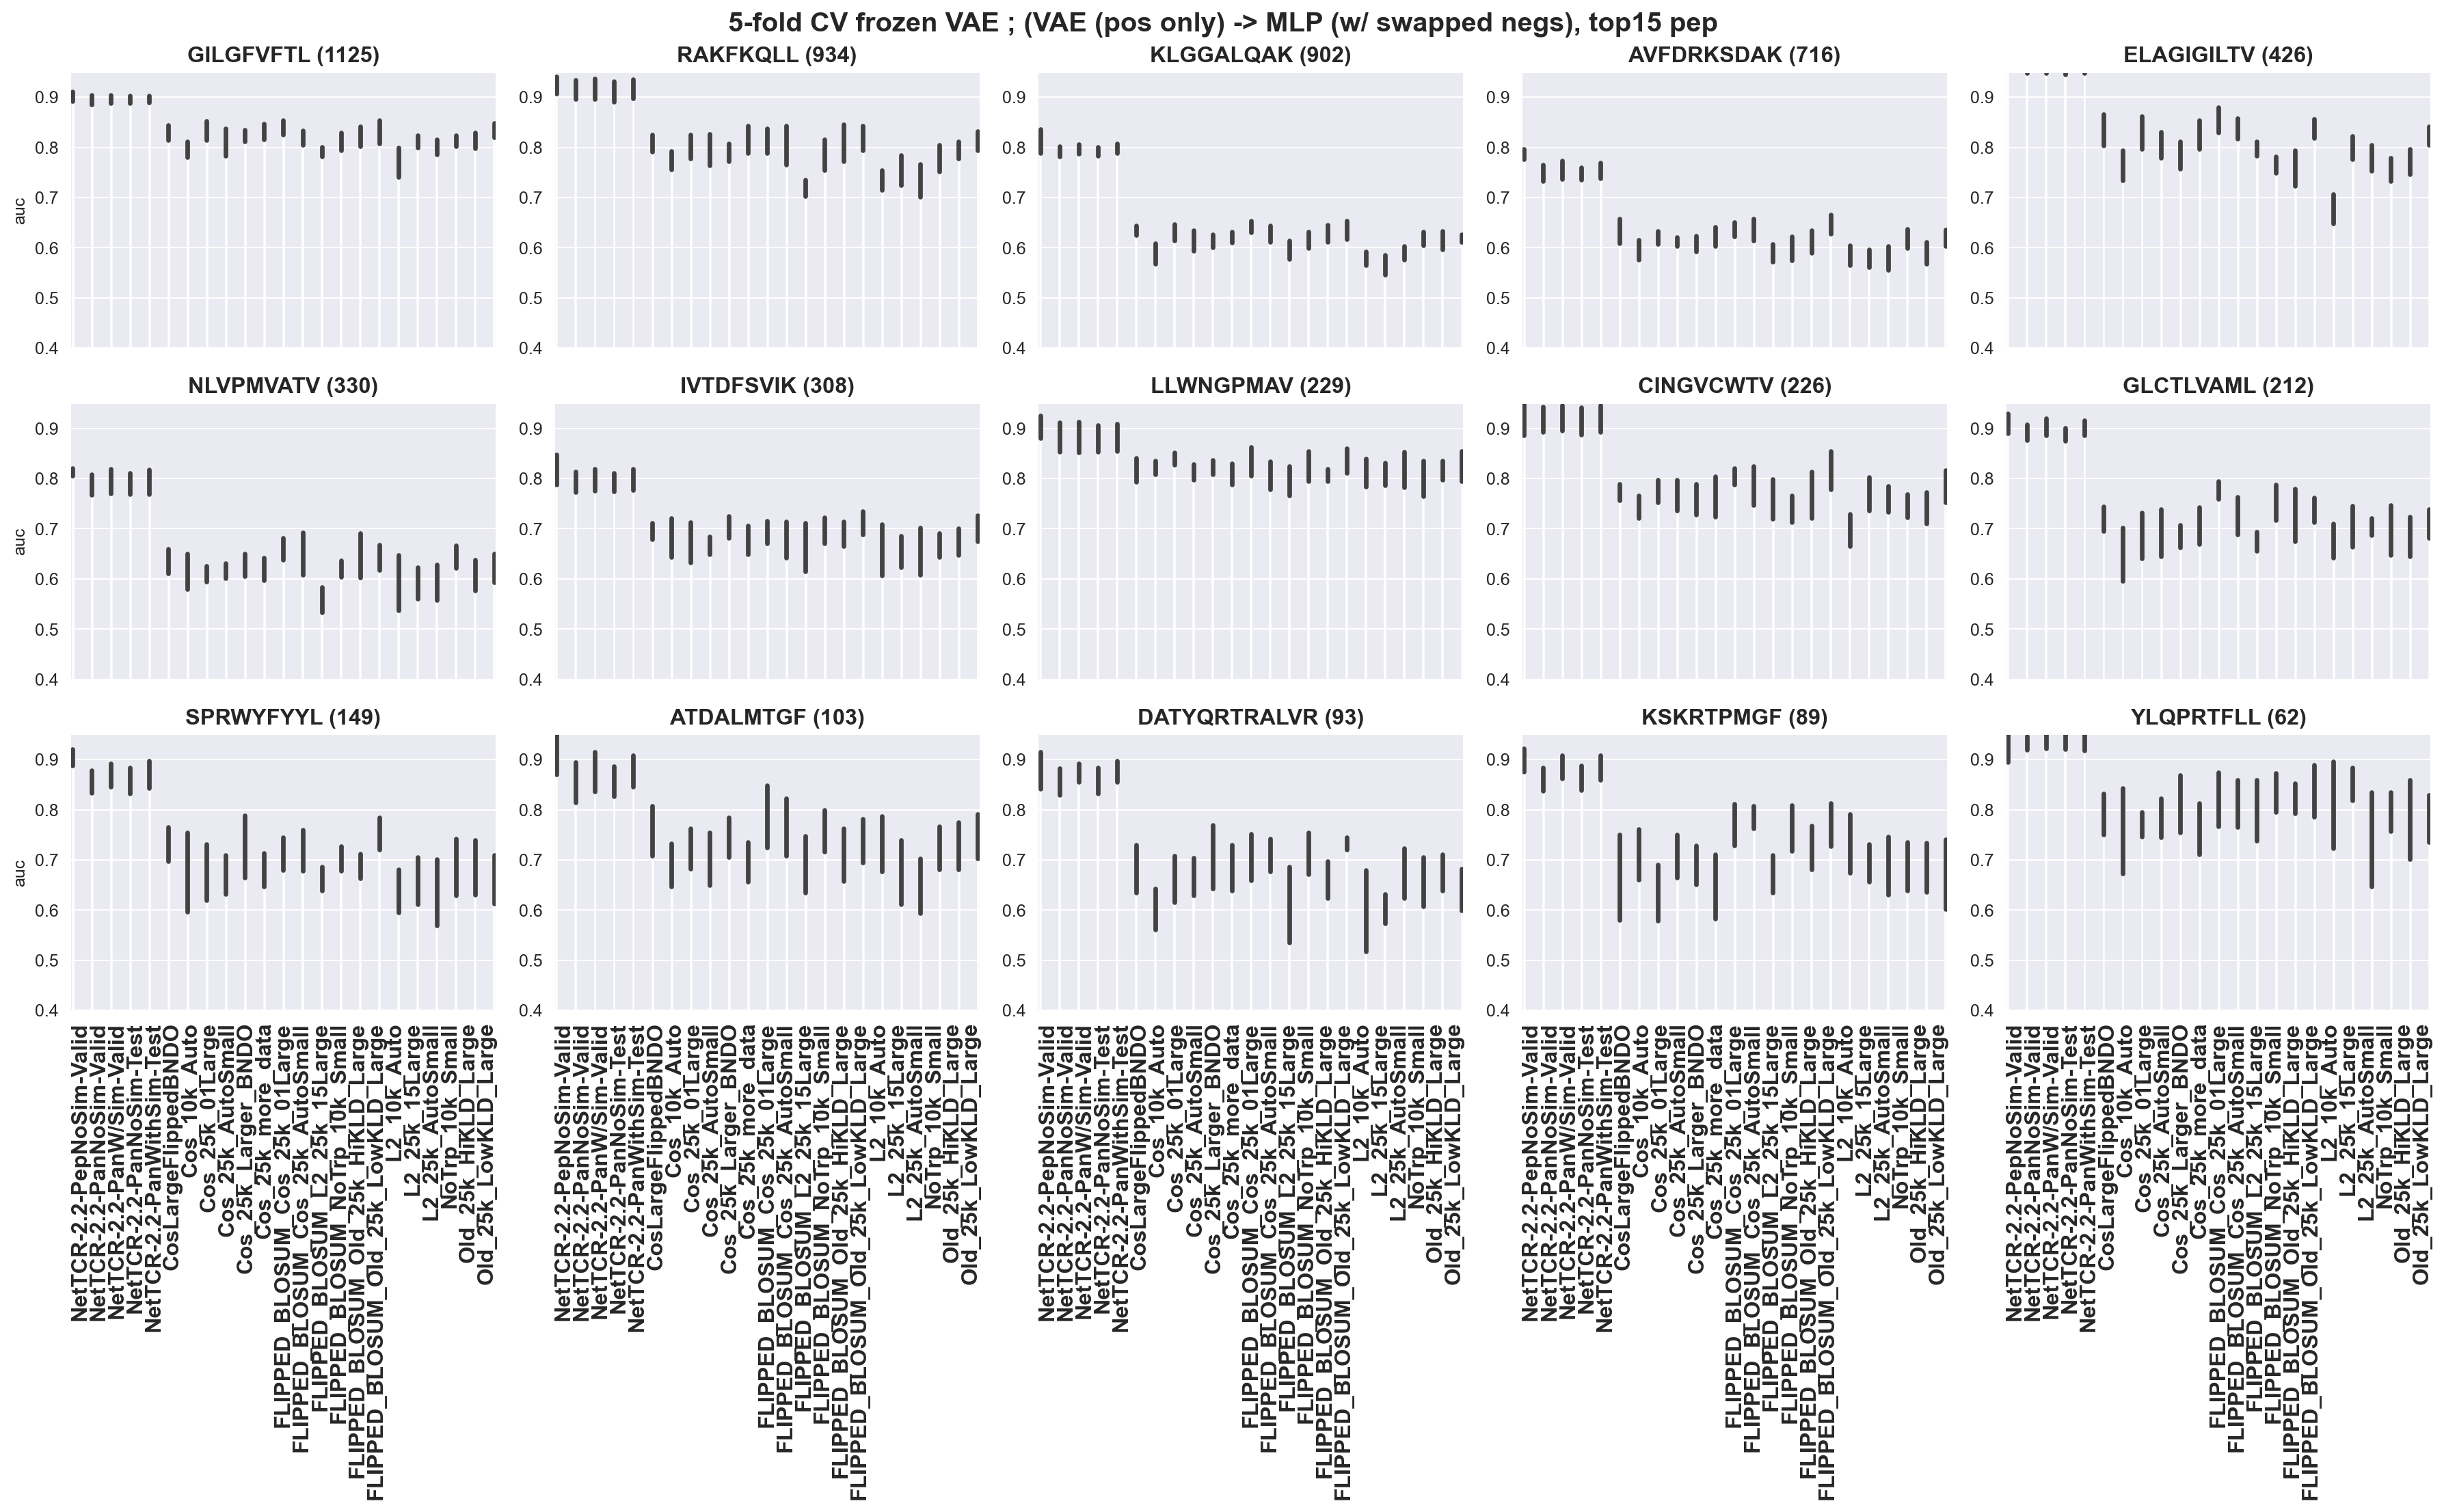

In [336]:
f,a = plt.subplots(3, 5, figsize=(20,12.5), sharex=True)
a = a.ravel()
xx = sorted([x for x in merged.name.unique() if 'nettcr' not in x.lower()])
yy = [x for x in merged.name.unique() if 'nettcr' in x.lower()]
order = yy+xx
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

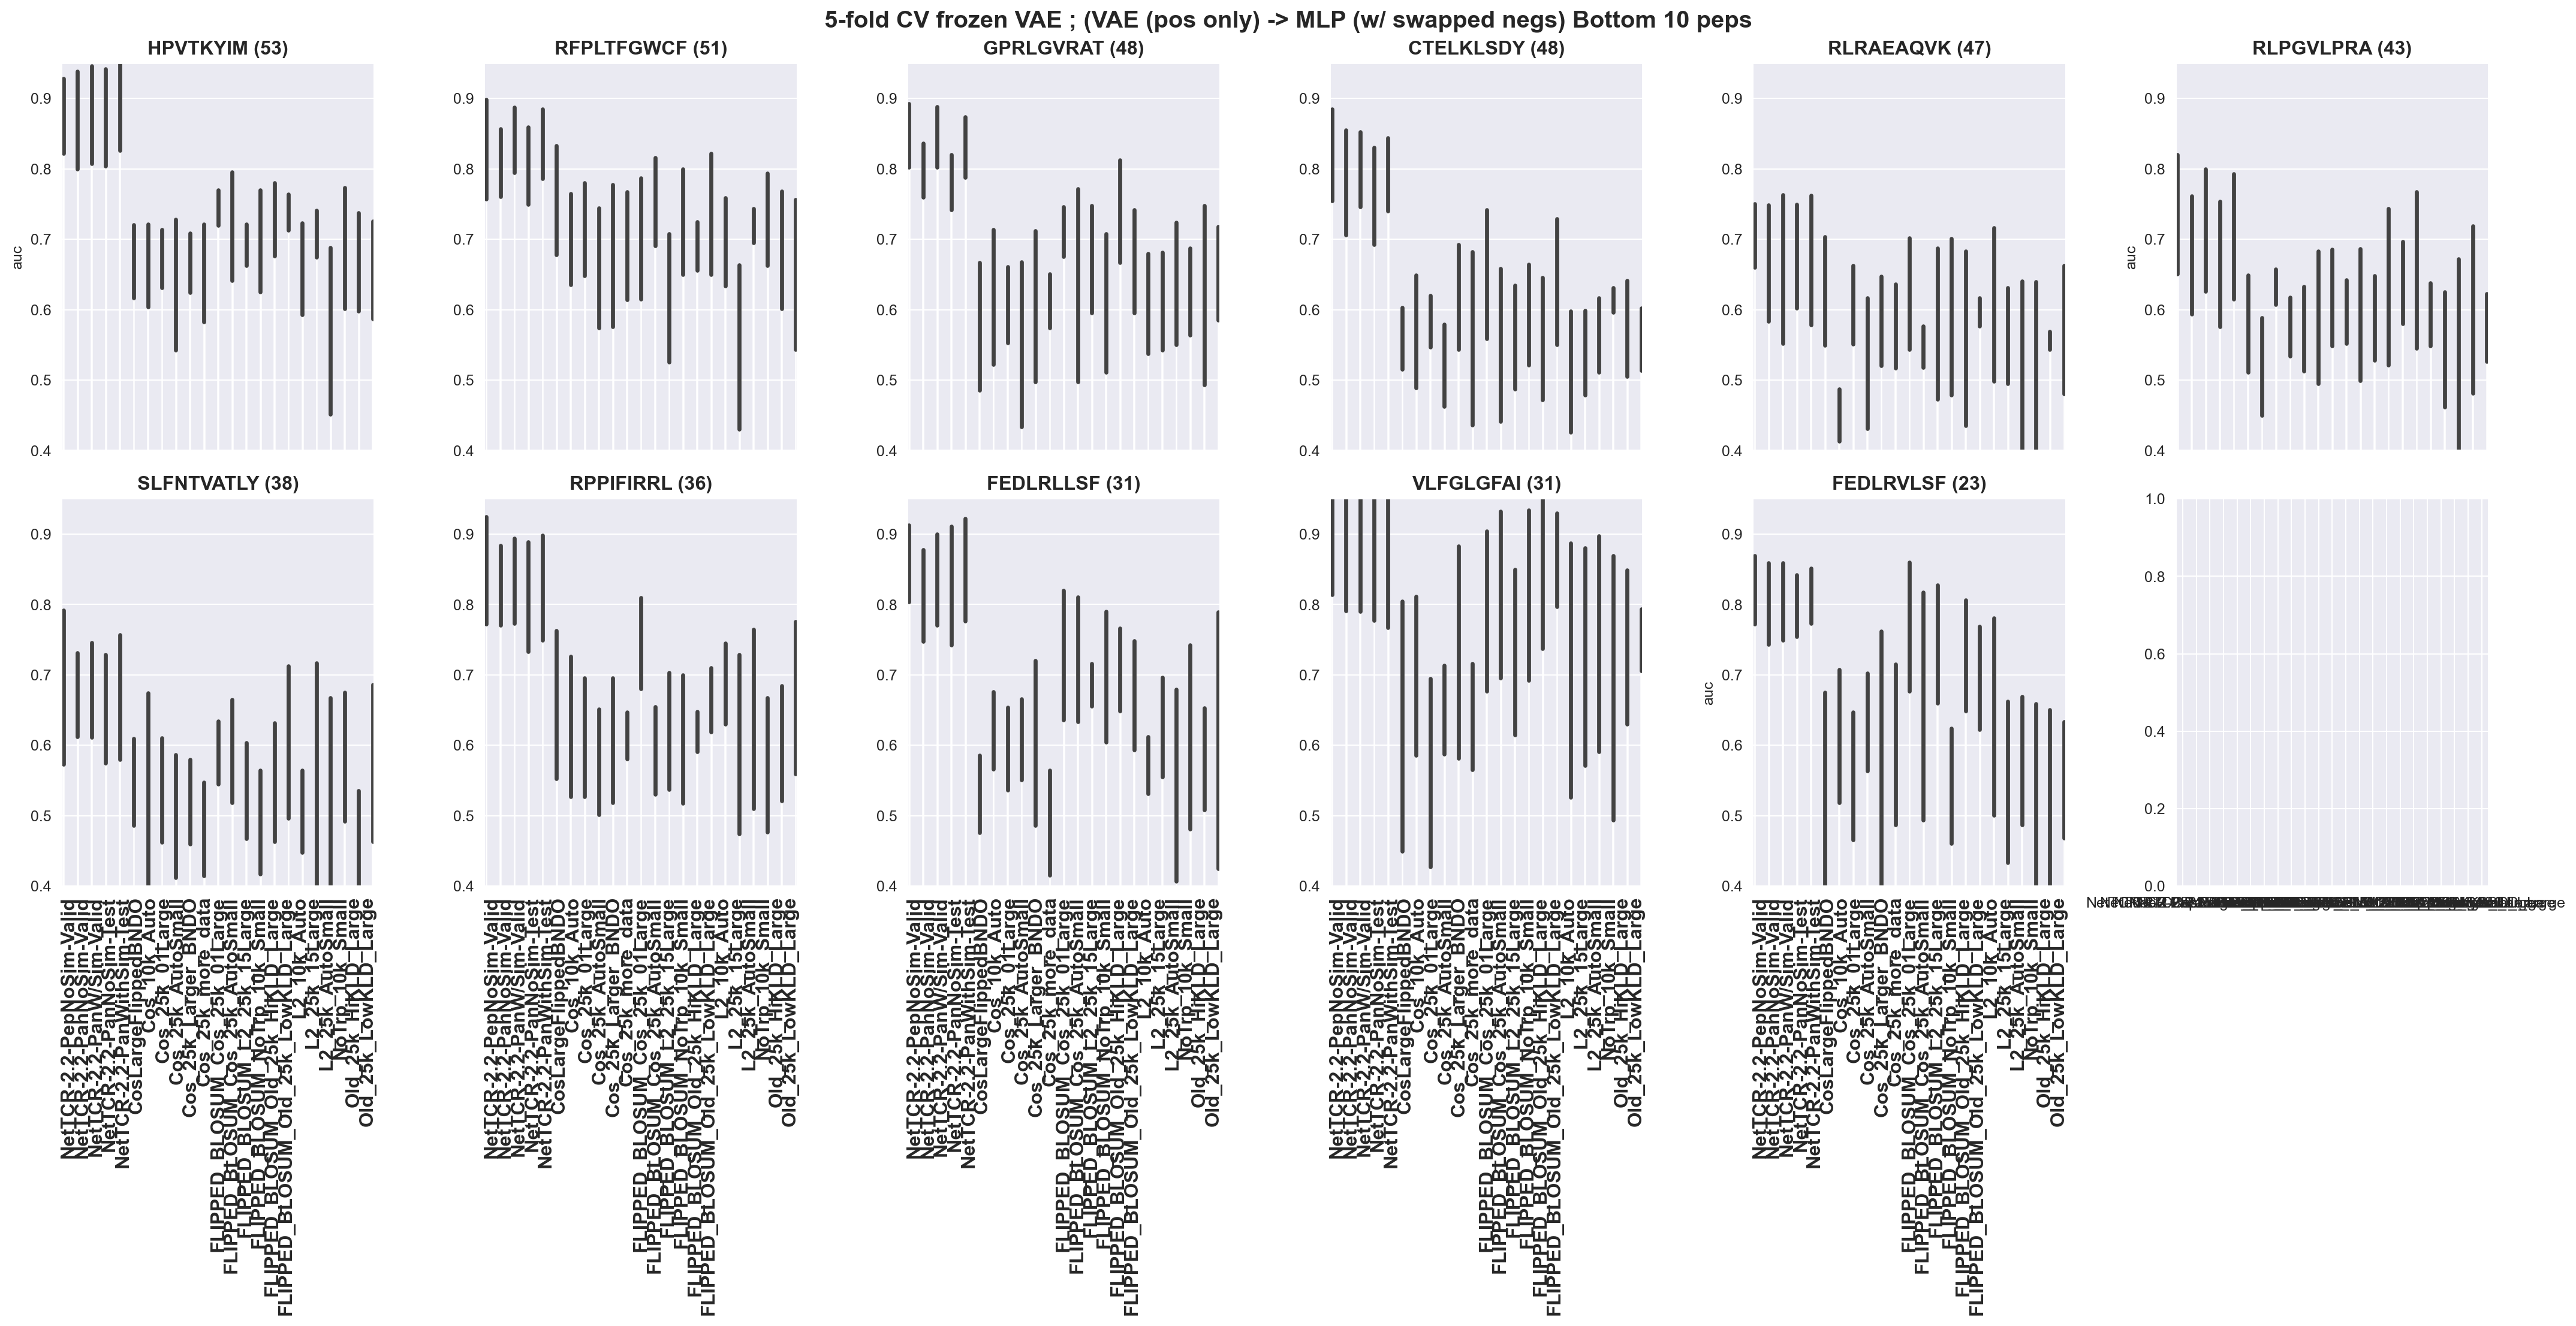

In [337]:
f,a = plt.subplots(2, 6, figsize=(24,12.5), sharex=True)
a = a.ravel()
xx = sorted([x for x in merged.name.unique() if 'nettcr' not in x.lower()])
yy = [x for x in merged.name.unique() if 'nettcr' in x.lower()]
order = yy+xx
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.barplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

## here redo plot with only few models

In [331]:
merged.name.unique()

array(['FLIPPED_BLOSUM_NoTrp_10k_Small', 'FLIPPED_BLOSUM_L2_25k_15Large',
       'FLIPPED_BLOSUM_Old_25k_LowKLD_Large',
       'FLIPPED_BLOSUM_Cos_25k_01Large',
       'FLIPPED_BLOSUM_Cos_25k_AutoSmall',
       'FLIPPED_BLOSUM_Old_25k_HiKLD_Large', 'NoTrp_10k_Small',
       'Cos_25k_01Large', 'Cos_10k_Auto', 'Cos_25k_Larger_BNDO',
       'Cos_25k_more_data', 'CosLargeFlippedBNDO', 'Old_25k_LowKLD_Large',
       'L2_10k_Auto', 'Old_25k_HiKLD_Large', 'Cos_25k_AutoSmall',
       'L2_25k_15Large', 'L2_25k_AutoSmall', 'NetTCR-2.2-PepNoSim-Valid',
       'NetTCR-2.2-PanNoSim-Valid', 'NetTCR-2.2-PanW/Sim-Valid',
       'NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PanWithSim-Test'],
      dtype=object)

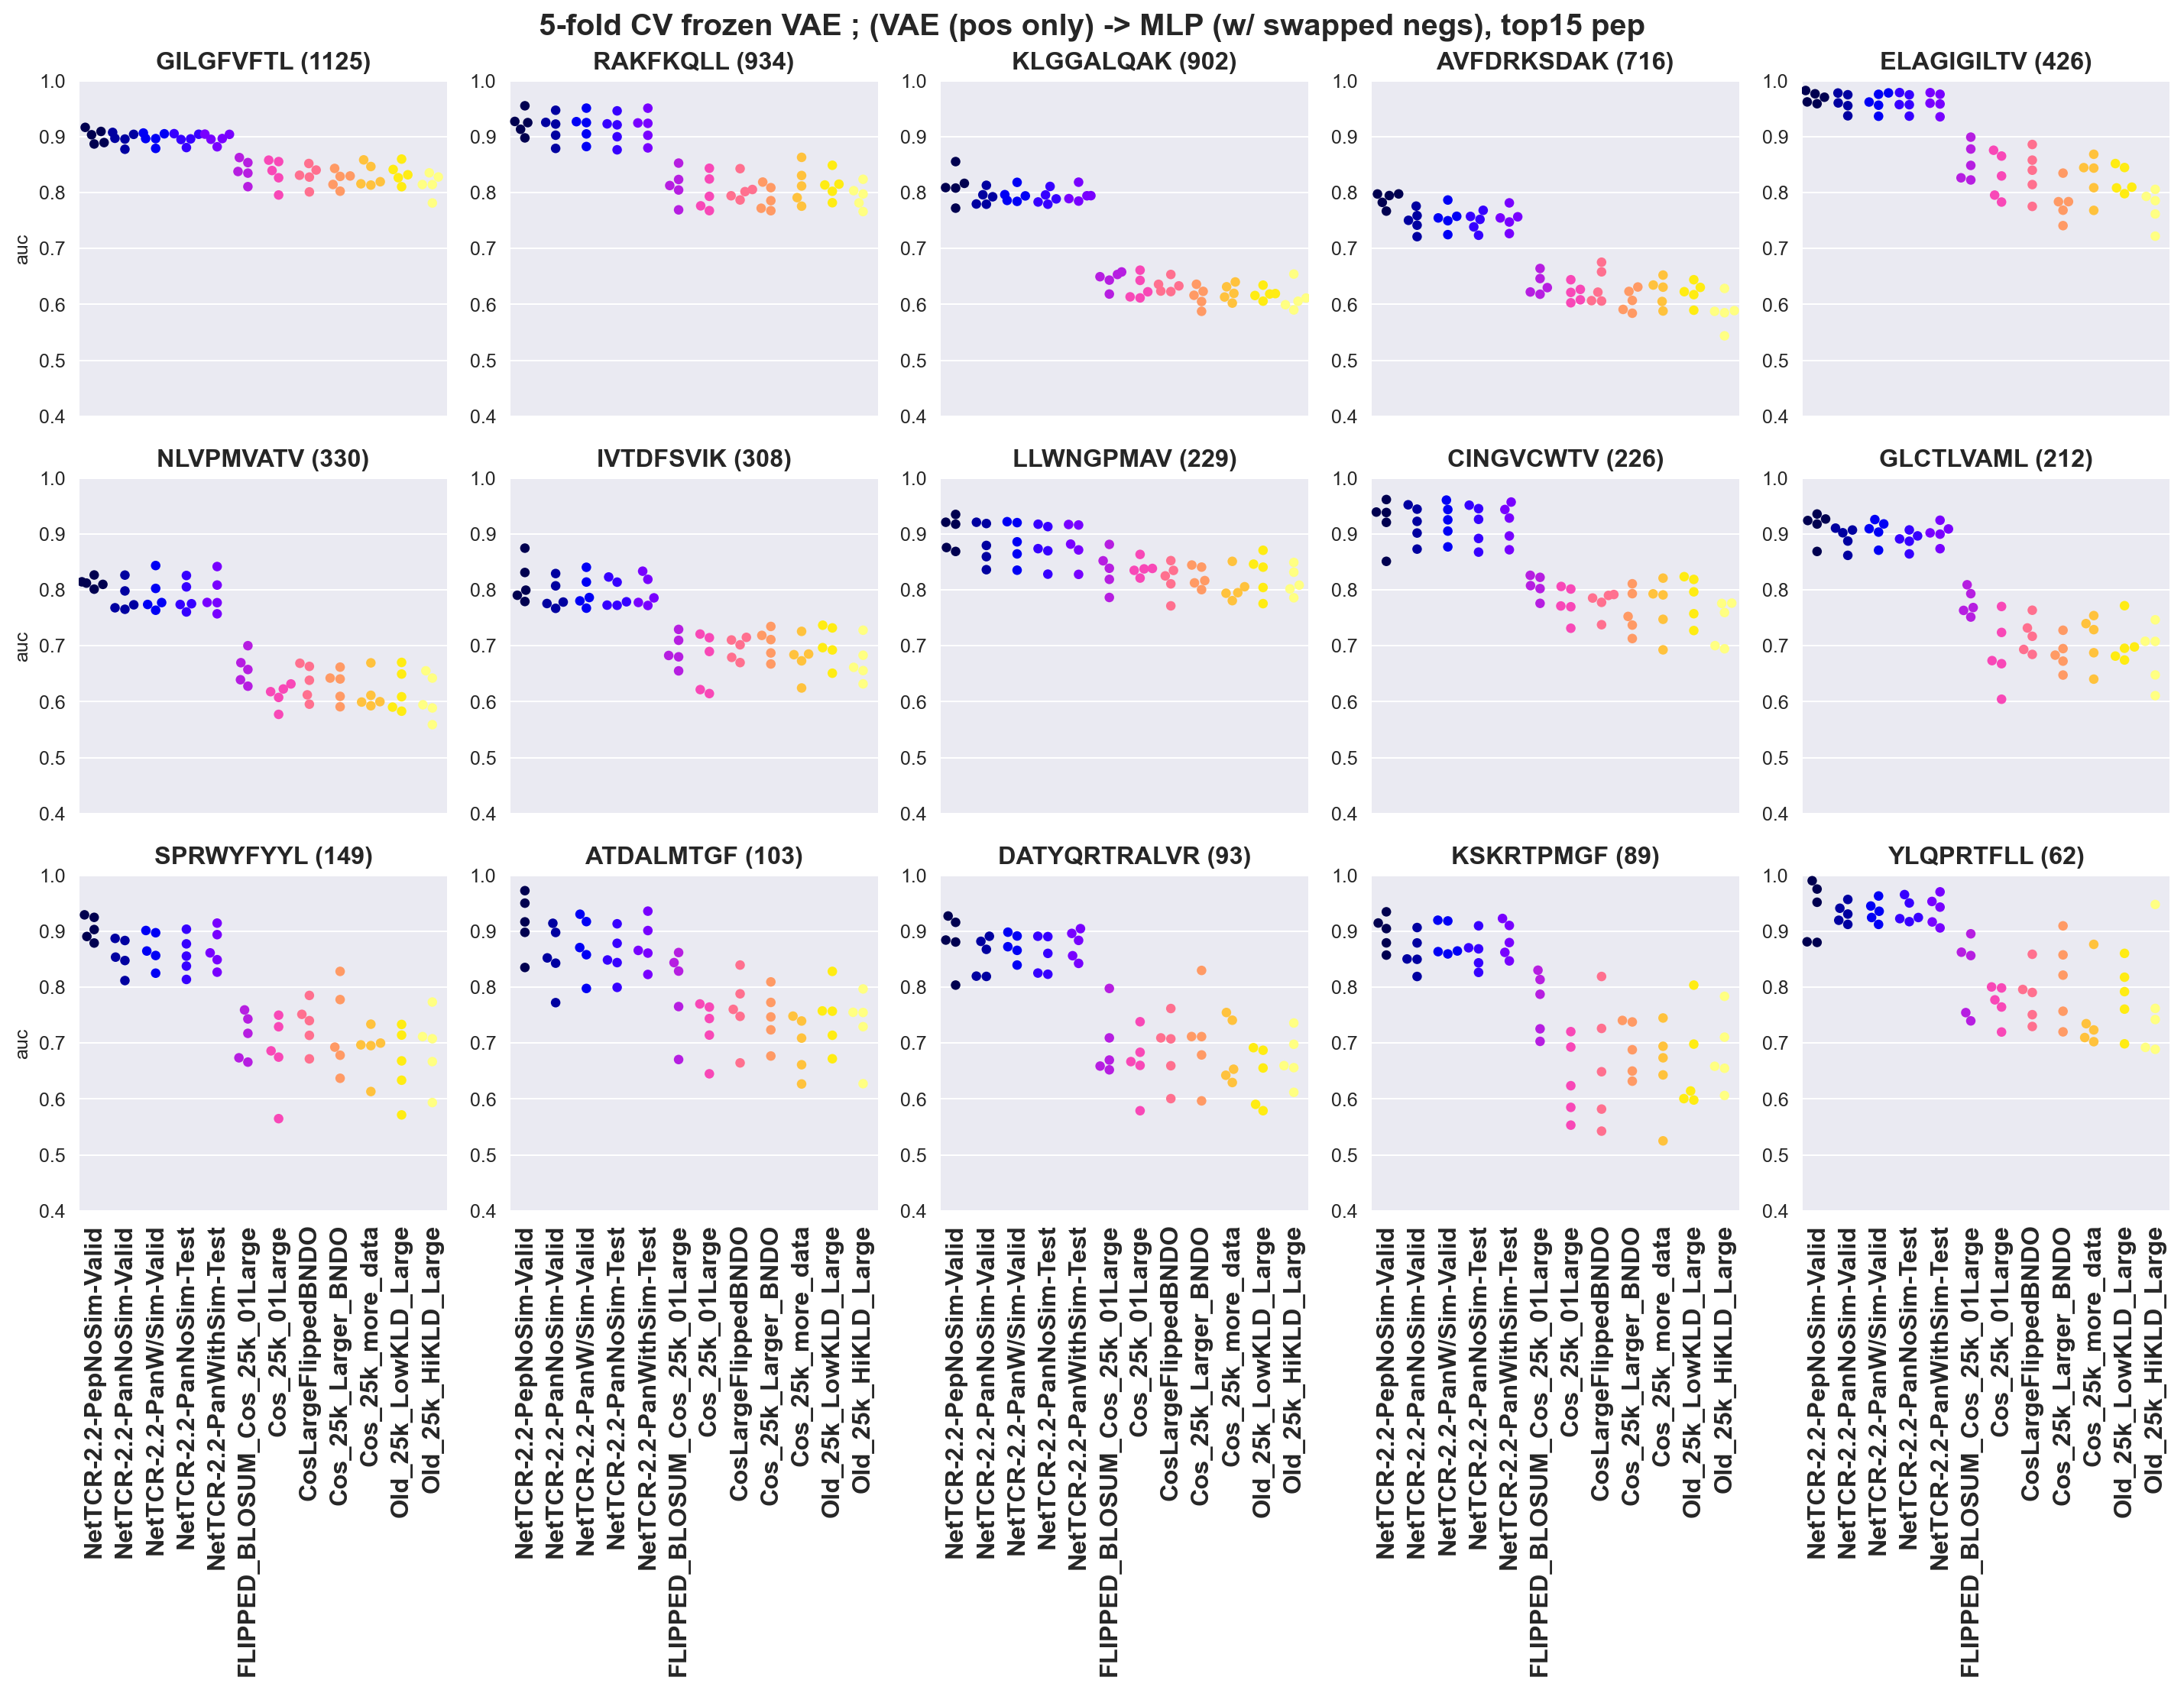

In [332]:
# AUC TOP 15 PEPS
f,a = plt.subplots(3, 5, figsize=(16,12.5), sharex=True)
a = a.ravel()

order = ['NetTCR-2.2-PepNoSim-Valid', 'NetTCR-2.2-PanNoSim-Valid', 'NetTCR-2.2-PanW/Sim-Valid', 'NetTCR-2.2-PanNoSim-Test', 'NetTCR-2.2-PanWithSim-Test',
         'FLIPPED_BLOSUM_Cos_25k_01Large',
         'Cos_25k_01Large', 'CosLargeFlippedBNDO', 'Cos_25k_Larger_BNDO', 'Cos_25k_more_data', 'Old_25k_LowKLD_Large', 'Old_25k_HiKLD_Large']
sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,1])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

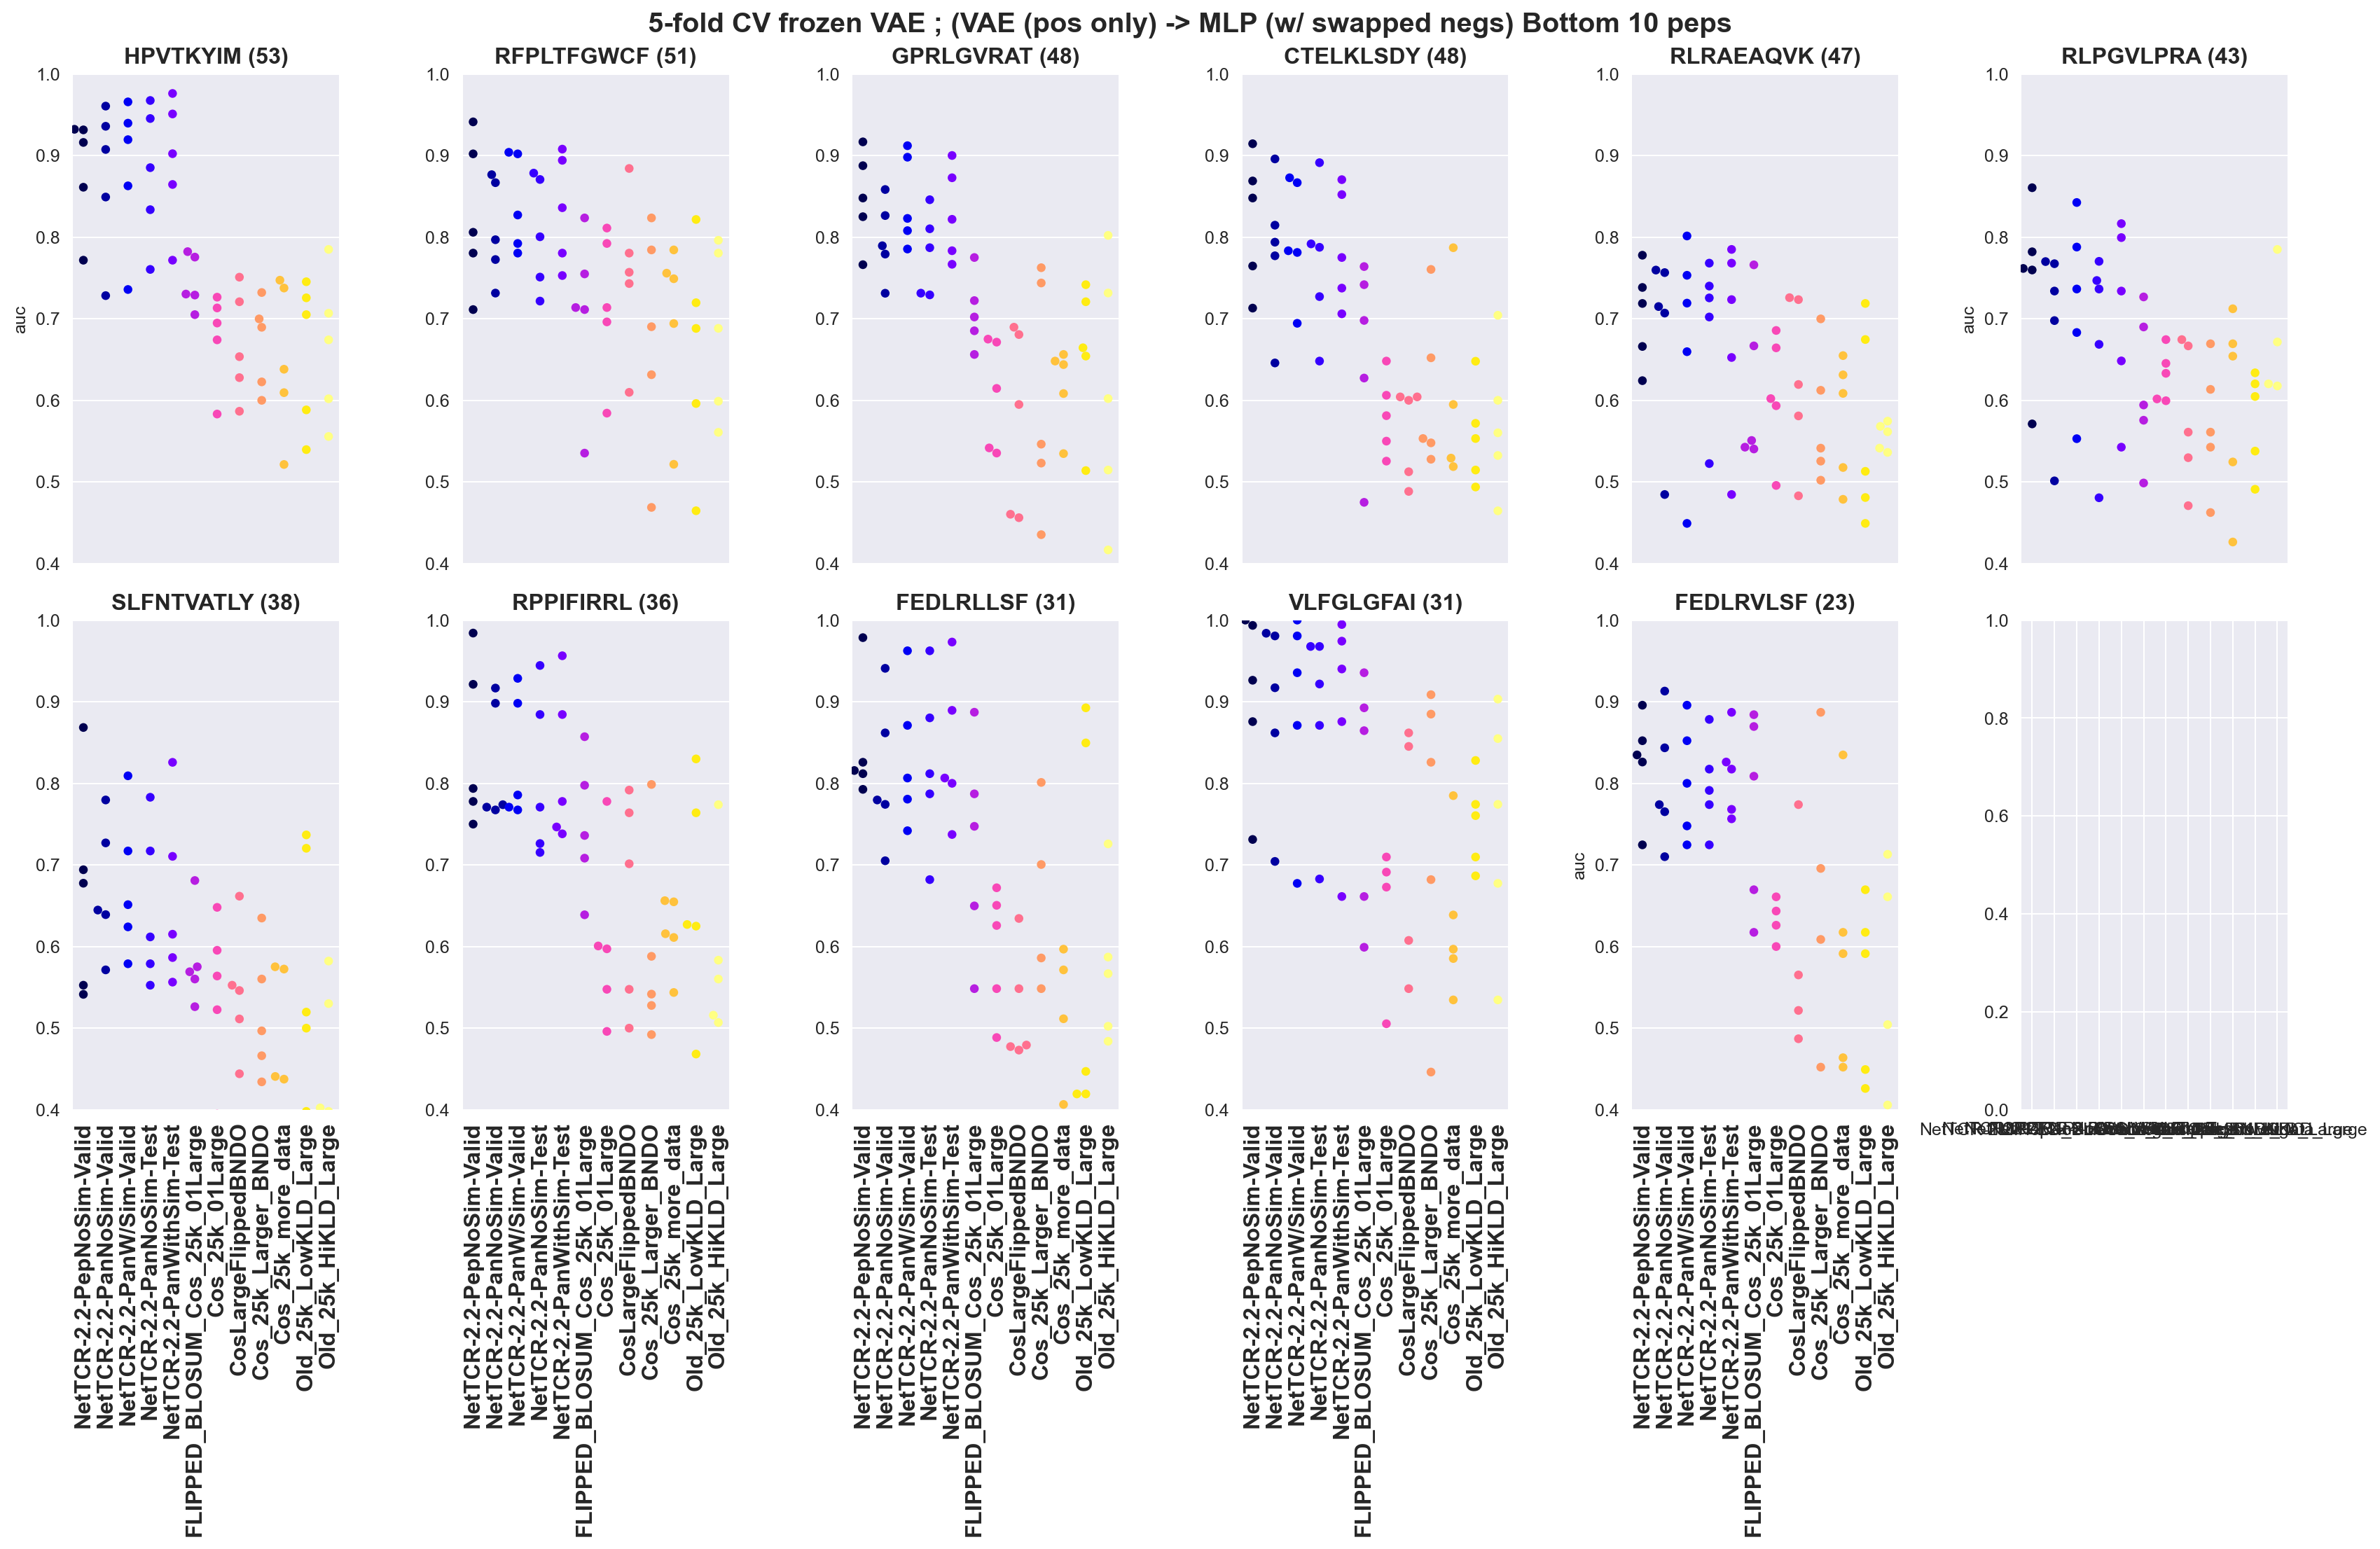

In [333]:
# AUC BOTTOM PEPS
f,a = plt.subplots(2, 6, figsize=(19,12.5), sharex=True)
a = a.ravel()

sns.set_palette(get_palette('gnuplot2', len(order)))

for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = merged.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,1])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

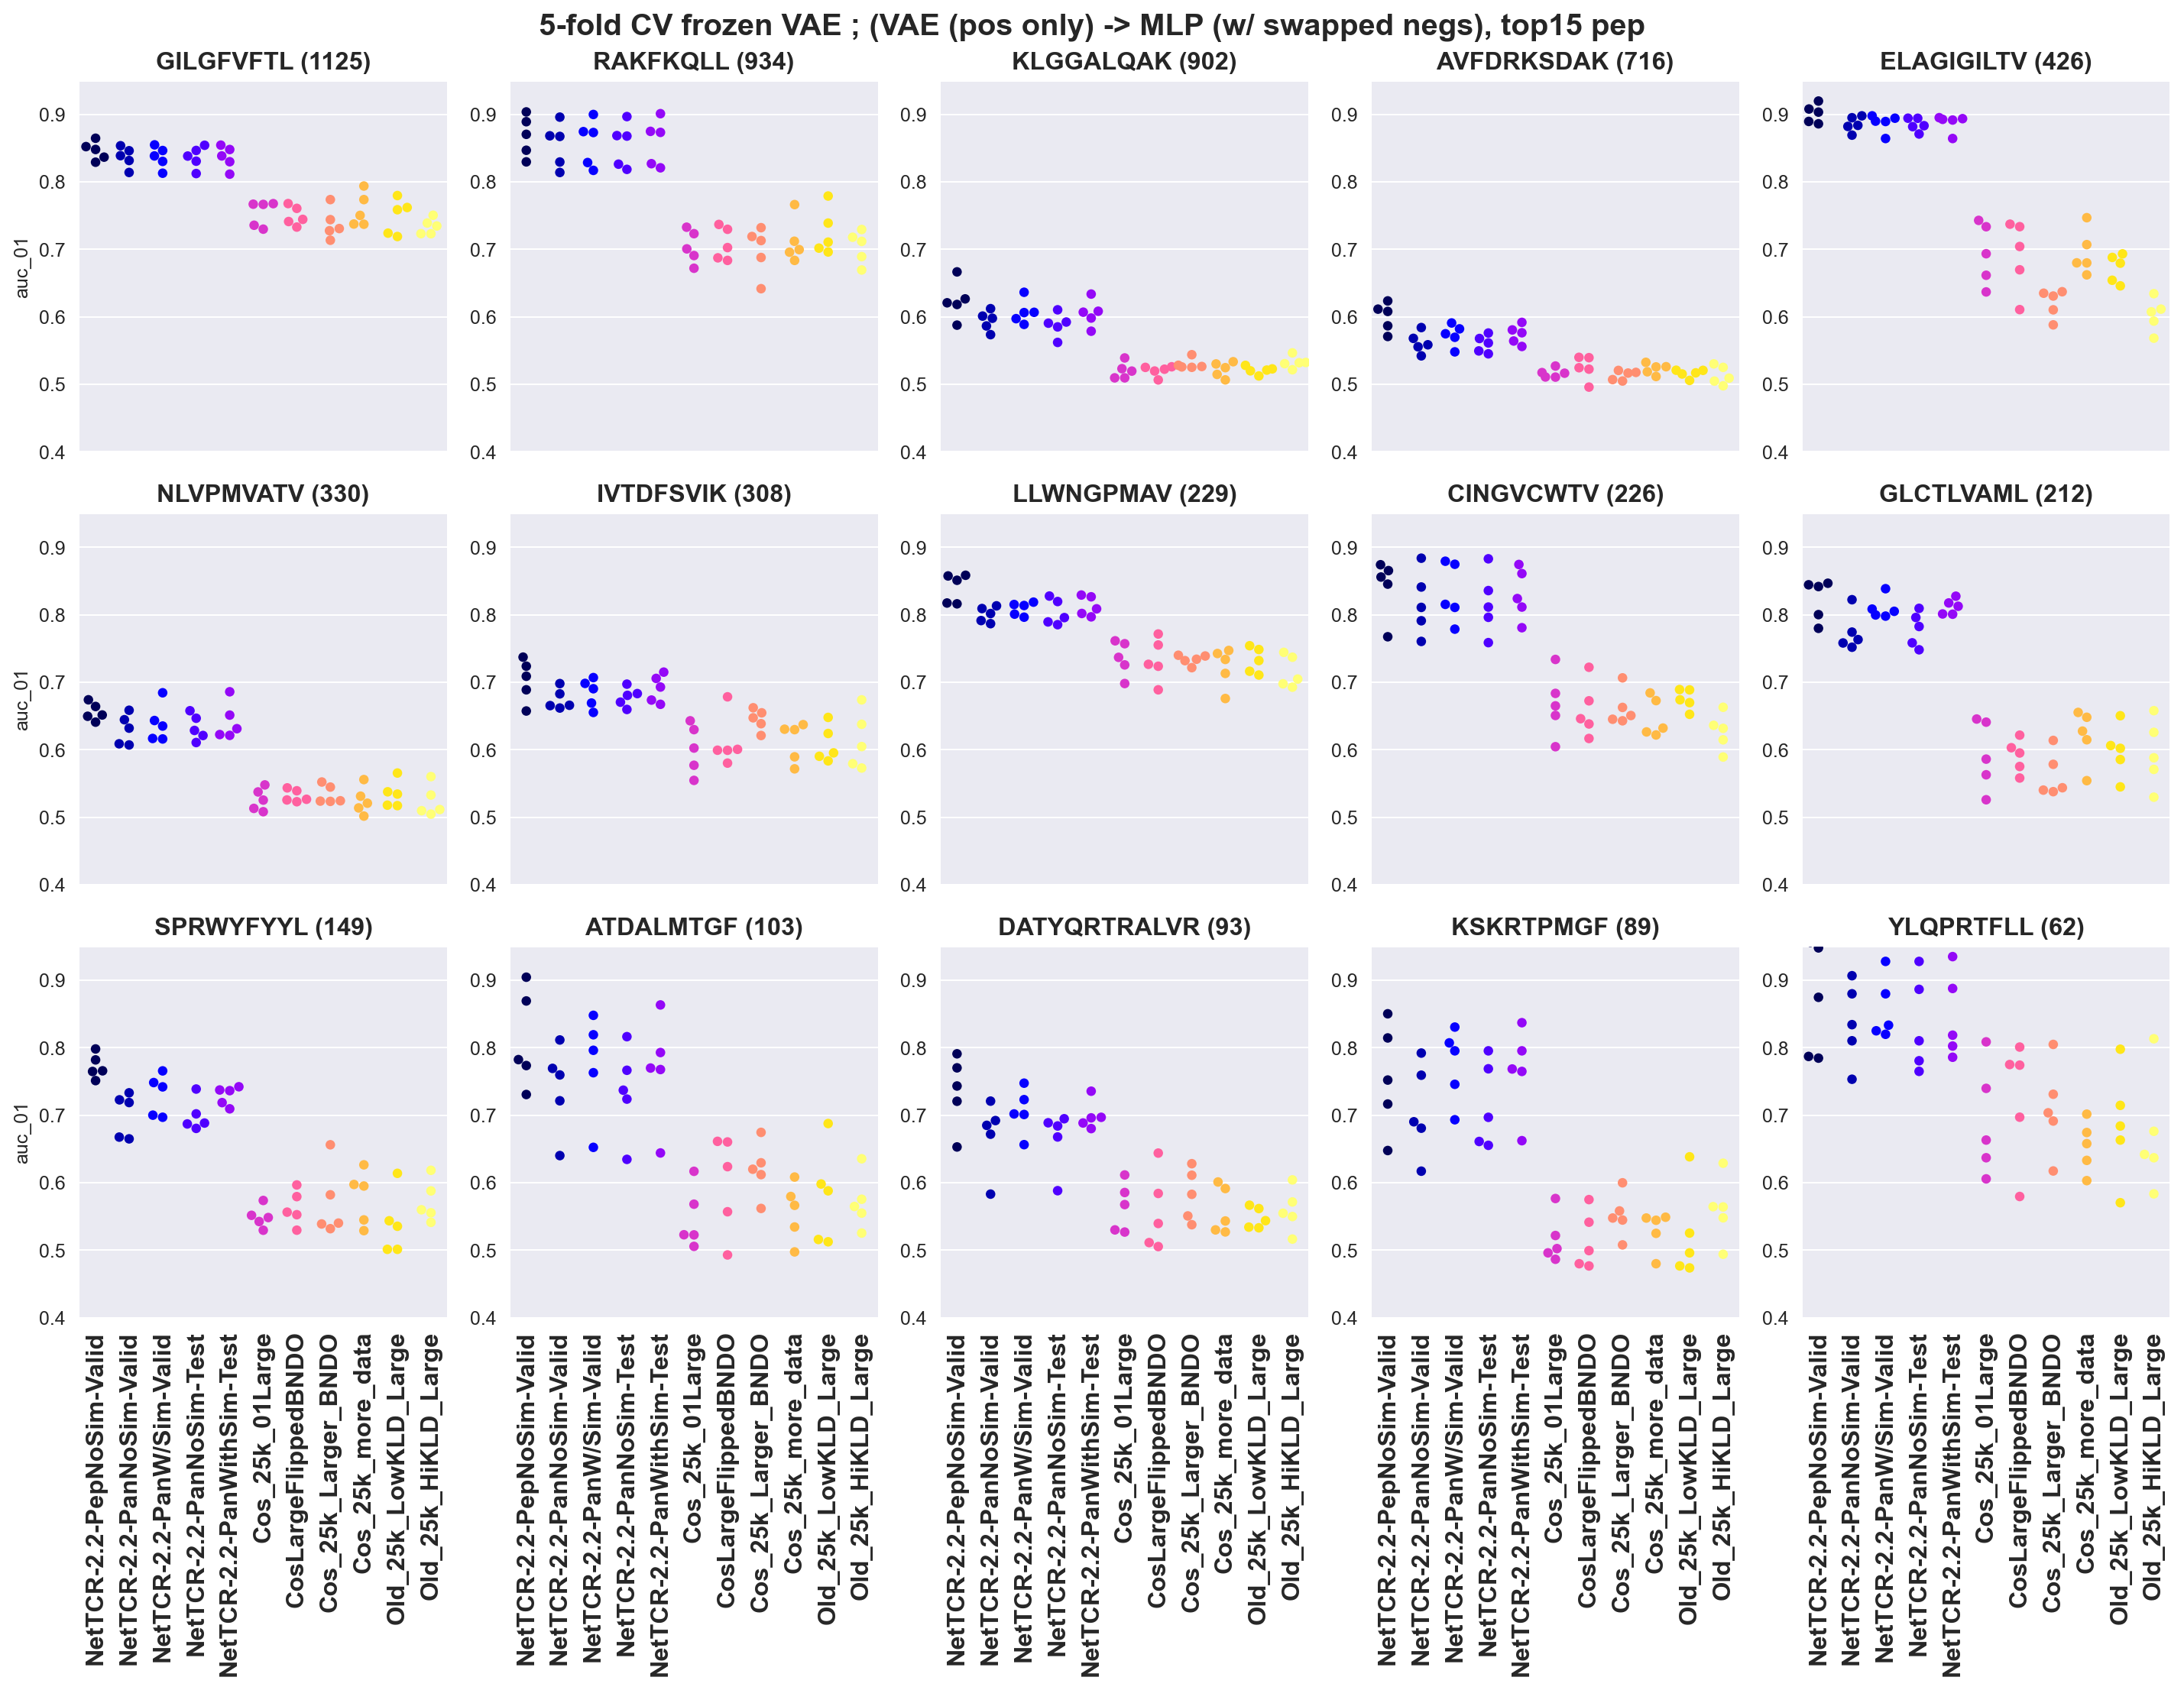

In [311]:
# AUC 01 TOP PEPS
f,a = plt.subplots(3, 5, figsize=(16,12.5), sharex=True)
a = a.ravel()


sns.set_palette(get_palette('gnuplot2', len(order)))
for i, (pep, ax) in enumerate(zip(peporder[:15], a)):
    tmp = clfs.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc_01', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=10:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs), top15 pep', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

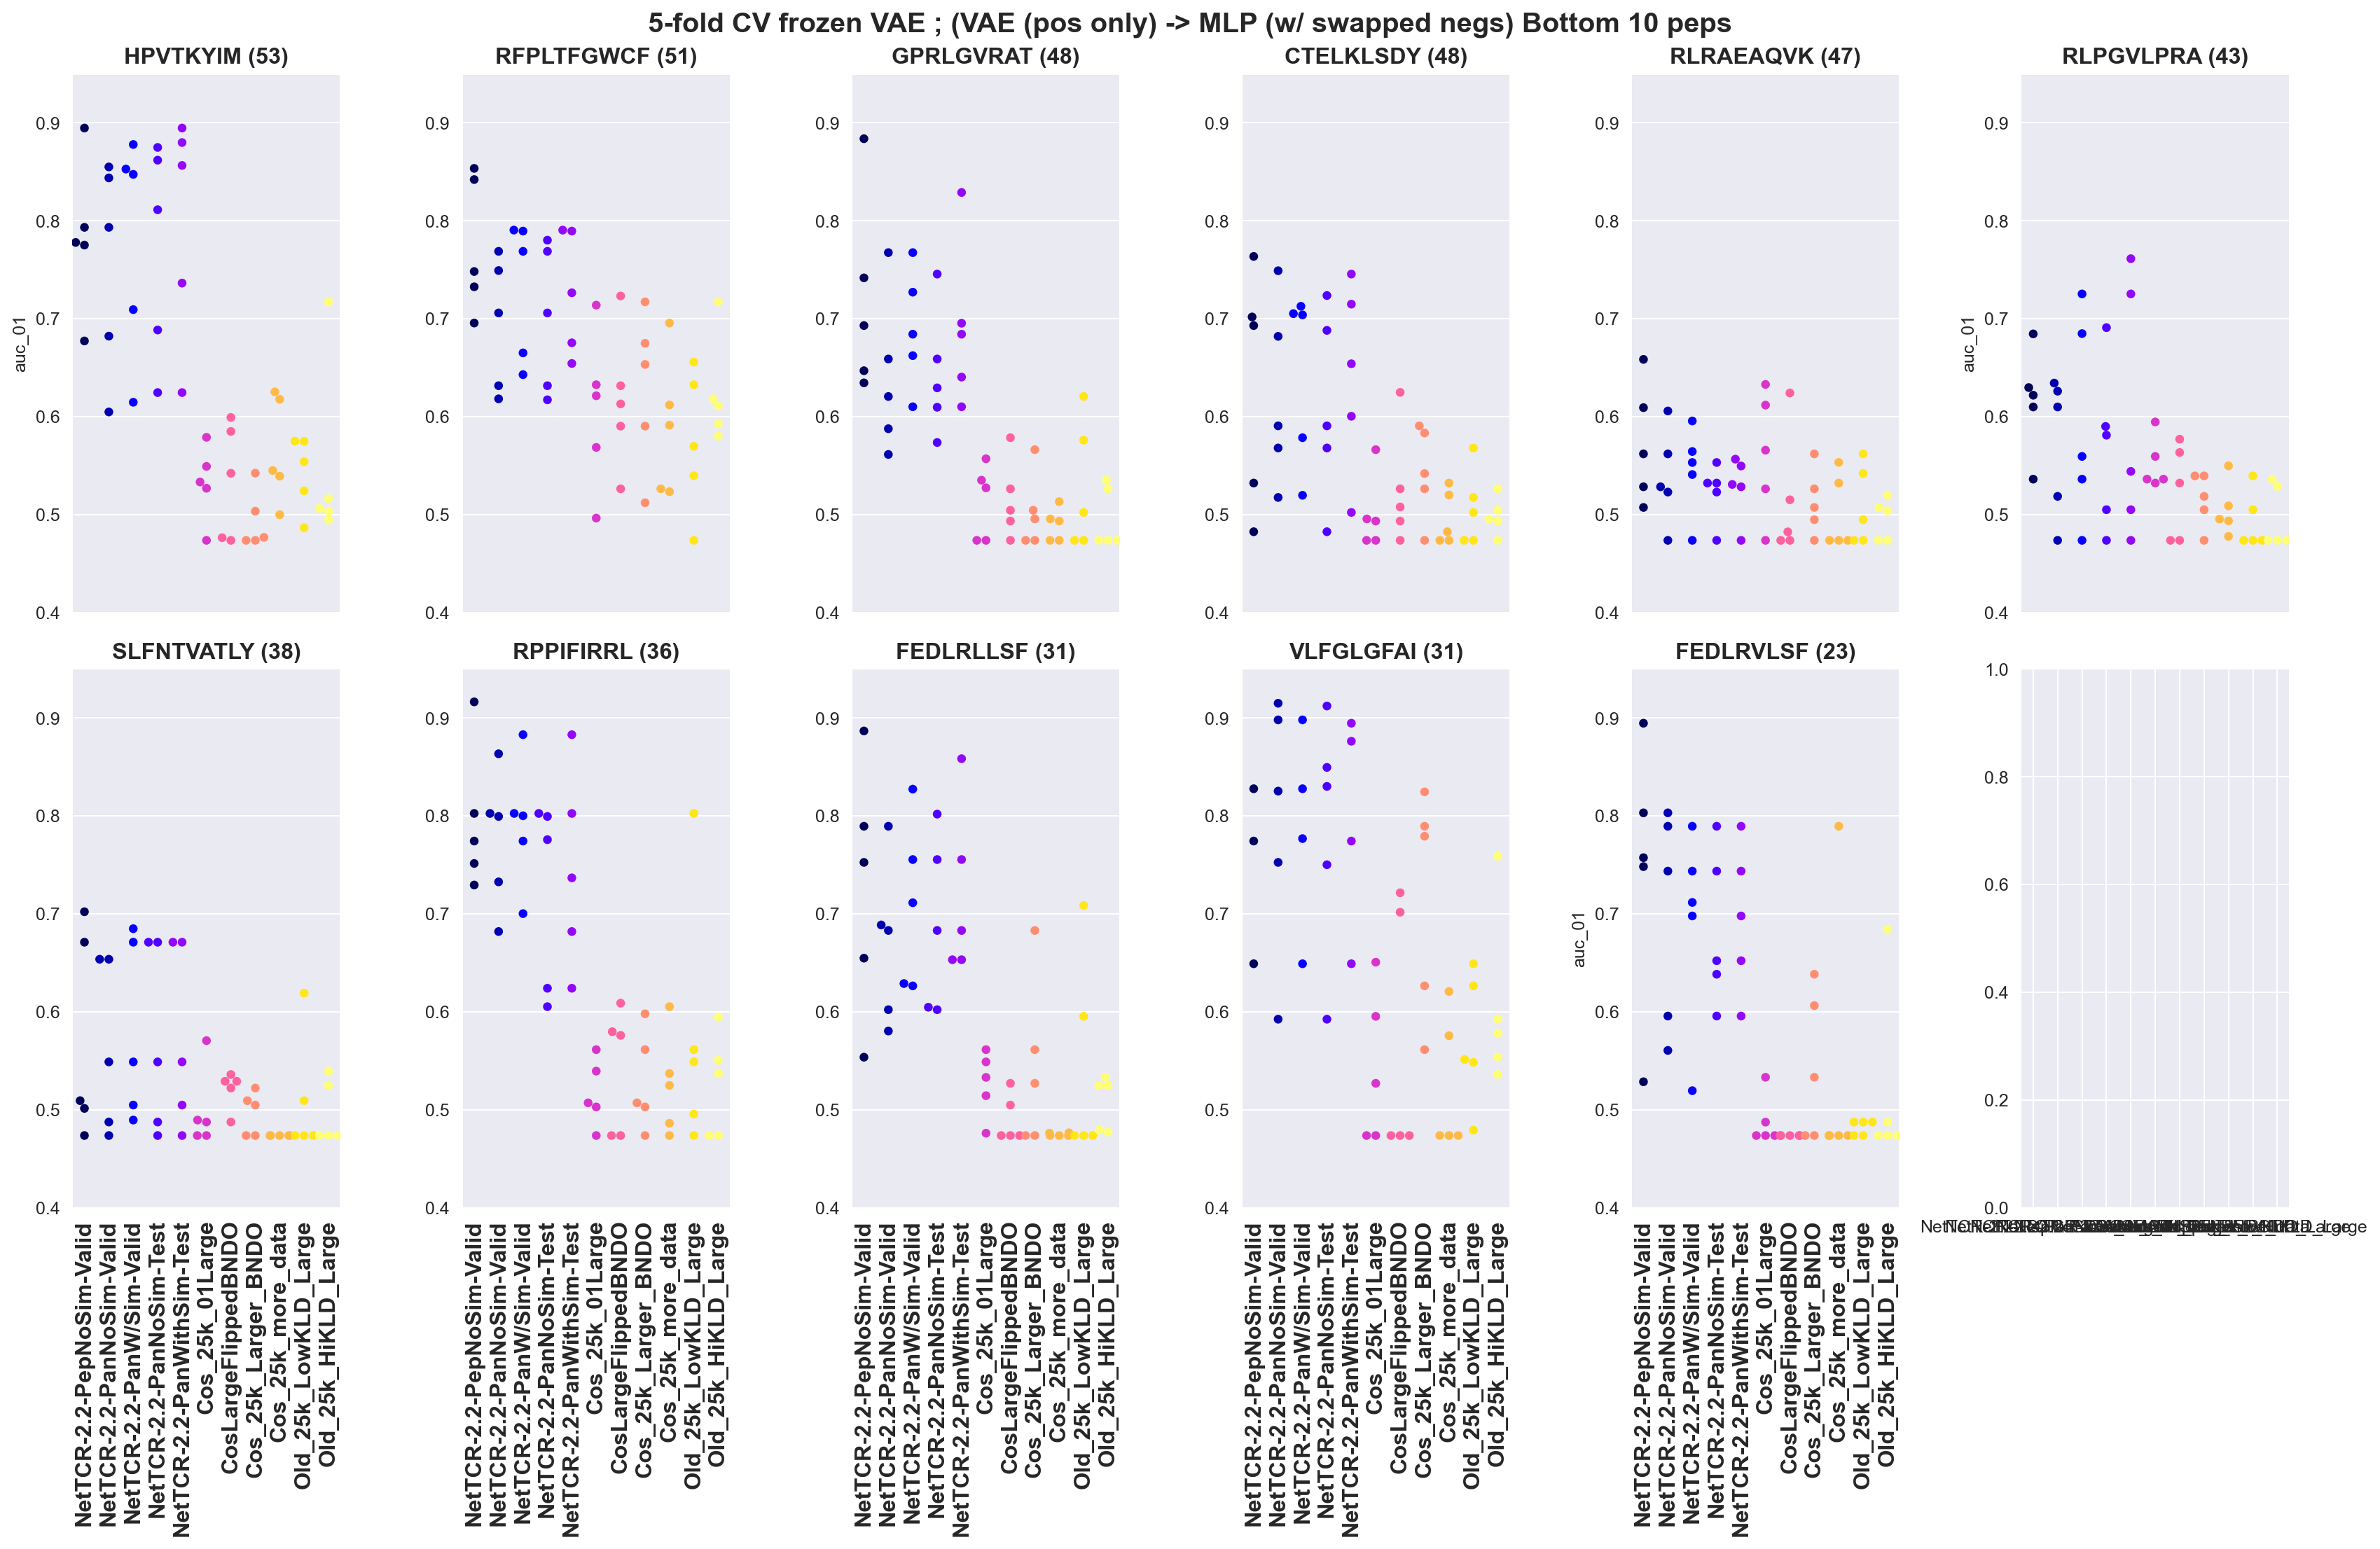

In [312]:
# AUC 01 BOTTOM 10 PEPS
f,a = plt.subplots(2, 6, figsize=(19,12.5), sharex=True)
a = a.ravel()

sns.set_palette(get_palette('gnuplot2', len(order)))

for i, (pep, ax) in enumerate(zip(peporder[15:], a)):
    tmp = clfs.reset_index().query('peptide==@pep')
    sns.swarmplot(data=tmp, x='name', y='auc_01', hue = 'name', ax=ax, 
                  order=order , hue_order=order)
    ax.set_ylim([0.4,.950])
    ax.set_title(f'{pep} ({len(df.query("peptide==@pep and binder==1"))})', fontsize=13, fontweight='semibold')
    if i not in [0, 5, 10]:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.legend('', frameon=False)
    if i>=6:
        ax.set_xticklabels(order, rotation=90, fontsize=13, fontweight='semibold')
f.suptitle('5-fold CV frozen VAE ; (VAE (pos only) -> MLP (w/ swapped negs) Bottom 10 peps', fontsize=16, fontweight='semibold')
f.tight_layout(pad=1.15)

## wtf

In [271]:
clfs.query('peptide in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False) 

,mean_auc,std_auc,max_auc,mean_auc01,std_auc01,max_auc01
name,,,,,,
NetTCR-2.2-PepNoSim,0.876100,0.064710,0.9823,0.770302,0.110003,0.9197
NetTCR-2.2-PanW/Sim,0.862798,0.071765,0.9780,0.753638,0.112776,0.8998
NetTCR-2.2-PanNoSim,0.858552,0.072370,0.9778,0.743014,0.114497,0.8978
CosLargeFlippedBNDO,0.738154,0.085135,0.8858,0.631902,0.088849,0.7715
Old_25k_LowKLD_Large,0.734542,0.092338,0.8706,0.633078,0.088810,0.7797
Cos_25k_01Large,0.730204,0.096217,0.8755,0.631108,0.092305,0.7677
Cos_25k_more_data,0.729132,0.091944,0.8683,0.633640,0.088524,0.7938
Cos_25k_Larger_BNDO,0.721826,0.085233,0.8442,0.623648,0.083935,0.7737
Cos_25k_AutoSmall,0.719248,0.089661,0.8548,0.621646,0.083967,0.7585


In [274]:
clfs.query('peptide not in @top10pep').groupby('name').agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), max_auc=('auc','max'),
                         mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std'), max_auc01=('auc_01','max')).sort_values('mean_auc',ascending=False)

,mean_auc,std_auc,max_auc,mean_auc01,std_auc01,max_auc01
name,,,,,,
NetTCR-2.2-PepNoSim,0.841066,0.102374,1.0000,0.733251,0.120969,1.0000
NetTCR-2.2-PanW/Sim,0.827555,0.103153,1.0000,0.714736,0.113042,1.0000
NetTCR-2.2-PanNoSim,0.812950,0.100500,0.9839,0.686420,0.110273,0.9151
Cos_25k_Larger_BNDO,0.650150,0.138538,0.9094,0.566279,0.085630,0.8246
L2_10k_Auto,0.648728,0.131975,0.9395,0.551875,0.074422,0.8062
Old_25k_LowKLD_Large,0.645210,0.121071,0.8925,0.544691,0.076319,0.8026
CosLargeFlippedBNDO,0.642789,0.127782,0.8841,0.549070,0.080708,0.8009
NoTrp_10k_Small,0.638081,0.139327,0.9086,0.557719,0.076131,0.8175
Cos_25k_01Large,0.638070,0.097520,0.8111,0.544355,0.064928,0.8086


In [272]:
clfs.groupby(['name']).agg(mean_auc=('auc','mean'), std_auc= ('auc','std'), mean_auc01=('auc_01', 'mean'), std_auc01=('auc_01','std')).sort_values('mean_auc',ascending=False)

,mean_auc,std_auc,mean_auc01,std_auc01
name,,,,
NetTCR-2.2-PepNoSim,0.854541,0.091113,0.747502,0.117837
NetTCR-2.2-PanW/Sim,0.841110,0.093642,0.729698,0.114095
NetTCR-2.2-PanNoSim,0.830489,0.093118,0.708187,0.114850
Old_25k_LowKLD_Large,0.679568,0.118823,0.578686,0.091795
CosLargeFlippedBNDO,0.679468,0.122155,0.580928,0.092866
Cos_25k_Larger_BNDO,0.677718,0.125453,0.588344,0.089171
Cos_25k_01Large,0.673506,0.106608,0.577722,0.087253
NoTrp_10k_Small,0.667255,0.124903,0.578028,0.078545
Cos_25k_more_data,0.664491,0.115594,0.572912,0.089683


In [630]:
n_hidden_clf = 50
n_layers = 3
dropout=0
layers = []
batchnorm=True
dec=True
for _ in range(n_layers):
    if dec:
        layers.append(nn.Linear(n_hidden_clf, n_hidden_clf//2))
        n_hidden_clf = n_hidden_clf//2
    else:
        layers.append(nn.Linear(n_hidden_clf, n_hidden_clf))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout))
    if batchnorm:
        layers.append(nn.BatchNorm1d(n_hidden_clf))
layers.append(nn.Linear(n_hidden_clf, 1))
layers

[Linear(in_features=50, out_features=25, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=25, out_features=12, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=12, out_features=6, bias=True),
 ReLU(),
 Dropout(p=0, inplace=False),
 BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=6, out_features=1, bias=True)]

In [ ]:
zn = pd.read_csv('../../cedar_icerfire/data/mutant/